In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using CSV, DataFrames
df = CSV.read("datos/viviendas.csv", DataFrame)
first(df, 5)

Row,precio,area,dormitorios,baños,habitaciones,calleprincipal,huespedes,sotano,calentador,climatizacion,garaje,centrico,amueblado
,Int64,Int64,Int64,Int64,Int64,String3,String3,String3,String3,String3,Int64,String3,String15
1,13300000,7420,4,2,3,si,no,no,no,si,2,si,amueblado
2,12250000,8960,4,4,4,si,no,no,no,si,3,no,amueblado
3,12250000,9960,3,2,2,si,no,si,no,no,2,si,semi-amueblado
4,12215000,7500,4,2,2,si,no,si,no,si,3,si,amueblado
5,11410000,7420,4,1,2,si,si,si,no,si,2,no,amueblado


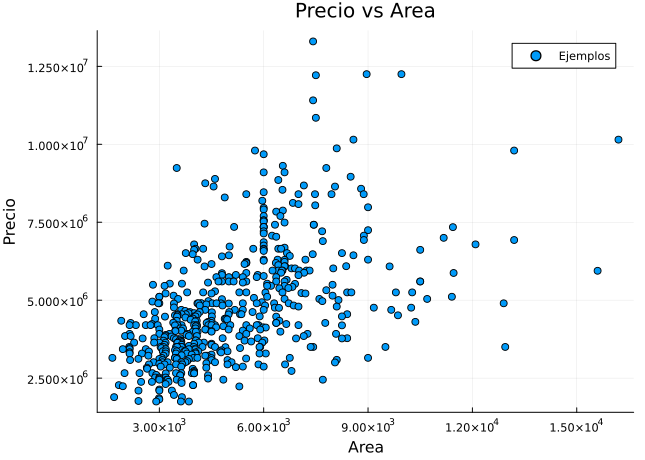

In [3]:
using Plots
plt = scatter(df.area, df.precio, xlabel="Area", ylabel="Precio", title="Precio vs Area", label = "Ejemplos", fmt=:png,)

In [4]:
precio(area, θ) = θ[1] .+ θ[2] * area

precio (generic function with 1 method)

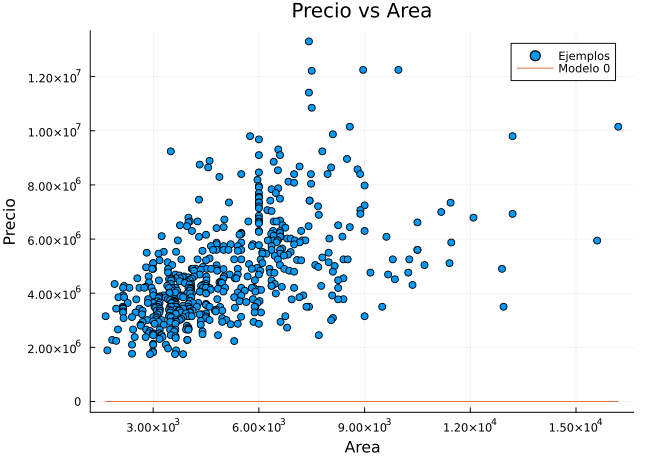

In [5]:
θ = [0.0, 0.0]
plot!(df.area, precio(df.area, θ), label = "Modelo 0")

In [6]:
function coste(θ, X, Y)
    m = length(Y)
    return sum((precio(X, θ) .- Y).^2) / (2 * m)
end

coste(θ, df.area, df.precio)

1.3106916364659266e13

In [7]:
function gradiente_descendente!(θ, X, Y, α)
    # Calculamos el número de ejemplos
    m = length(Y)
    # Actualizamos el término independiente del modelo lineal.
    θ[1] -= α * sum(precio(X, θ) - Y) / m
    # Actualizamos la pendiente del modelo lineal.
    θ[2] -= α * sum((precio(X, θ) - Y) .* X) / m
    return θ
end

gradiente_descendente! (generic function with 1 method)

In [8]:
gradiente_descendente!(θ, df.area, df.precio, 1e-8)
θ

2-element Vector{Float64}:
   0.04766729247706422
 267.22919804579385

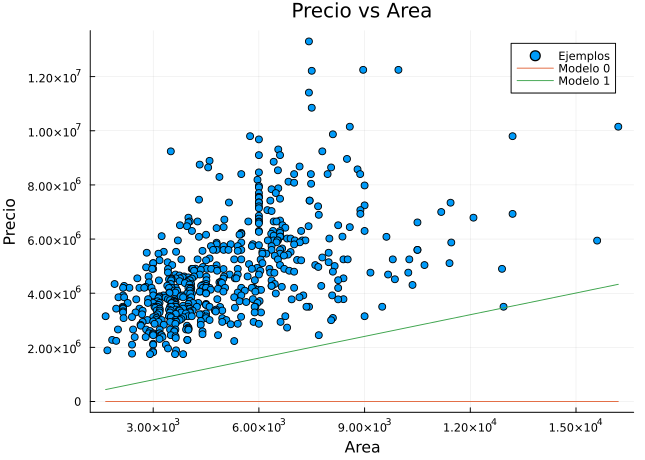

In [9]:
plot!(df.area, precio(df.area, θ), label = "Modelo 1")

In [10]:
coste(θ, df.area, df.precio)

7.080823787113201e12

In [11]:
costes = Float64[]
for i = 1:10
    gradiente_descendente!(θ, df.area, df.precio, 1e-8)
    push!(costes, coste(θ, df.area, df.precio))
end
costes

10-element Vector{Float64}:
 4.230808760870044e12
 2.882906194020343e12
 2.2454213686913755e12
 1.9439256128790886e12
 1.8013344680594421e12
 1.7338965877160208e12
 1.7020021263374993e12
 1.6869177748236997e12
 1.6797836937723748e12
 1.6764096595632322e12

In [12]:
θ = [0.0, 0.0]
costes = [0, coste(θ, df.area, df.precio)]
i = 1
while abs(costes[end] - costes[end-1]) / costes[end-1] > 0.000001
    i += 1
    gradiente_descendente!(θ, df.area, df.precio, 1e-8)
    push!(costes, coste(θ, df.area, df.precio))
end
i

23

In [13]:
θ = [0.0, 0.0]
costes = [coste(θ, df.area, df.precio)]
for i = 1:10
    gradiente_descendente!(θ, df.area, df.precio, 0.0001)
    push!(costes, coste(θ, df.area, df.precio))
end
costes

11-element Vector{Float64}:
 1.3106916364659266e13
 1.114133369099188e20
 1.0856750832581238e27
 1.05794371802143e34
 1.0309206941949286e41
 1.004587918634273e48
 9.789277603492545e54
 9.539230386975057e61
 9.29557011881276e68
 9.058133657380397e75
 8.826762028174244e82